In [82]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.feature_extraction import image

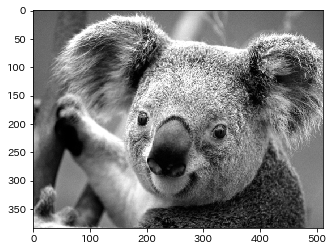

In [83]:
# read image
path = 'koala.png'
img = imageio.imread(path) 
plt.imshow(img, 'gray')

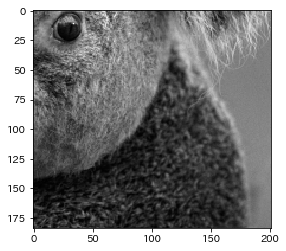

In [84]:
# crop_image
crop_h = 300
crop_w = 400
crop_size = 100
crop_img = img[crop_h - crop_size : crop_h+crop_size+1, crop_w-crop_size:crop_w+crop_size+1]
plt.imshow(crop_img, 'gray')

In [240]:
PATCH_WIDTH = 2 # patch width
PATCH_SIZE = PATCH_WIDTH * PATCH_WIDTH + 1 # patch size
ALPHA = 0.01 # hypter paramter
KNN_COUNT = 5 # neghborの数

In [241]:
# 一様分布に従うランダムな重みを作成
# この重みはpatchと同じサイズで中心ほど値が大きい正規分布に従う
# patchの重みの類似度を計算するときに中心ほど重みが大きくなるように計算する
axis = list(range(-PATCH_WIDTH, PATCH_WIDTH+1))
print(axis)
x, y = np.meshgrid(axis, axis) # axis×axisの格子状の点を作る
WEIGHT_DIST = norm.pdf(x) * norm.pdf(y) #　平均0分散1の正規分布を掛け合わせる
WEIGHT_DIST

[-2, -1, 0, 1, 2]


array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]])

In [242]:
# padding image
# おそらくpatchを探すときに探索範囲がpatch sizeで割り切れるための処理
pad_img = np.pad(crop_img, [PATCH_WIDTH, PATCH_WIDTH], 'symmetric')

print("crop image size: ", crop_img.shape)
print("padging image size: ", pad_img.shape)

HEIGHT, WIDTH = pad_img.shape
print("height: {}, width: {}, size: {}".format(HEIGHT, WIDTH, SIZE))

crop image size:  (184, 201)
padging image size:  (188, 205)
height: 188, width: 205, size: 38540


In [243]:
# patchを"全て"作成

PATCHES = image.extract_patches_2d(pad_img.T, (PATCH_SIZE, PATCH_SIZE))
print("patch shape: ", PATCHES.shape)
print("padding imageの大きさが{}x{}={}だから{}このpatchができる".format(HEIGHT,WIDTH,HEIGHT*WIDTH,HEIGHT*WIDTH))

# TODO
PATCHES = np.asarray([patch.T for patch in PATCHES]) # なんでてんち？
PATCH_COUNT = len(PATCHES)

patch shape:  (36984, 5, 5)
padding imageの大きさが188x205=38540だから38540このpatchができる


In [244]:
# initilize offse　
# かく場所iに対して，-i〜SIZE-iのオフセットをKNN_COUNT分だけ作成
rand = (PATCH_COUNT-1) * np.random.rand(PATCH_COUNT, KNN_COUNT) # 画像サイズ*KNN_countの大きさの0-(SIZE-1)の乱数の値をもつ行列を作成
tile = np.tile(np.arange(0, PATCH_COUNT), (KNN_COUNT, 1)).T # [[0,0,0,0,0],[1,1,1,1,1]...[38539, 38539, 38539, 38539, 38539]]
offsets = (rand - tile).astype(dtype=np.int)
offsets

array([[ 34068,  23204,  36480,  10935,  34492],
       [  2536,  26449,  28215,  36499,  22844],
       [  8685,  29889,  28310,  17923,  34510],
       ...,
       [  -235, -20754, -22608, -14458, -12975],
       [-21578, -20001, -31742, -34710,  -4467],
       [-18811, -10112, -28338, -24508, -15325]])

In [247]:
# initialize_weights

def patches_dissimilarity(patch1, patch2):
    diff = (patch1 - patch2) ** 2
    weighted_patch2 = diff * WEIGHT_DIST # diffを真ん中ほど大きい正規分布で重みずけ
    error = -ALPHA * diff.sum()
    return error

weights = np.ones([SIZE, KNN_COUNT])
for i in range(PATCH_SIZE):
    patch = PATCHES[i]
    for j in range(KNN_COUNT):
        offset = offsets[i, j] # get random offset
        offset_patch = PATCHES[i + offset, :, :]
        weights = patches_dissimilarity(patch, offset_patch)

weights

IndexError: index 36984 is out of bounds for axis 0 with size 36984

In [172]:
PATCHES[i, :, :]

array([[ 78, 105, 105,  78, 112],
       [104, 125, 125, 104, 125],
       [114, 135, 135, 114, 122],
       [ 79,  98,  98,  79,  91],
       [ 92, 102, 102,  92,  97]], dtype=uint8)

In [102]:
def initialize_weights(patches, offsets, alpha, g):
    [n, k] = offsets.shape
    weights = ones([n, k])
    for i in range(0, n):
        p0 = patches[i, :, :]
        for j in range(0, k):
            i2 = int(i + offsets[i, j])
            p2 = patches[i2, :, :]
            weights[i, j] = patches_dissimilarity(p0, p2, alpha, g)
    return weights

array([[0.42274596, 0.99029503, 0.47510225, 0.97446182, 0.80689428],
       [0.82441448, 0.09135693, 0.61408849, 0.93230068, 0.9817779 ],
       [0.25437048, 0.62676138, 0.20112461, 0.79508656, 0.2530367 ],
       ...,
       [0.95815934, 0.59820109, 0.52895621, 0.50721878, 0.45321653],
       [0.27905201, 0.54035415, 0.52231631, 0.03221701, 0.31433669],
       [0.70018028, 0.14573279, 0.9940347 , 0.95024277, 0.71929072]])

In [103]:
SIZE

38540